In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
%cd 'My Drive'/

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive
/gdrive/My Drive


In [2]:
PATH = "./dataset_ALTEGRAD/CA-HepTh.txt"

# Part 1

number of nodes 9877
number of edges 25998
number of connected components 429
number of nodes in the largest connected component of G: 8638
number of edges in the largest connected component of G: 24827
min 1
max 65
mean 5.264351523742027
median 3.0


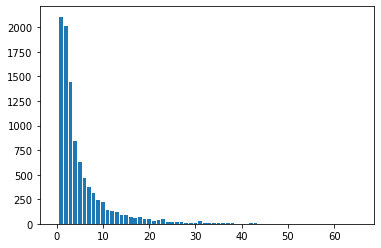

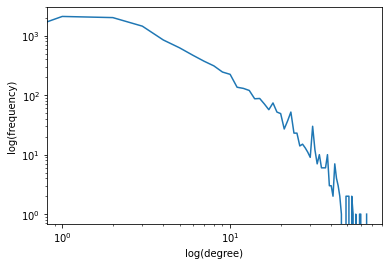

Global clustering coeff 0.2839996525875546


In [3]:
"""
Graph Mining - ALTEGRAD - Dec 2021
"""

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


############## Task 1

G = nx.readwrite.edgelist.read_edgelist(PATH, delimiter = "\t")
print('number of nodes', len(G.nodes))
print('number of edges', len(G.edges))



############## Task 2

largest_cc = max(nx.connected_components(G), key=len)
print("number of connected components", nx.number_connected_components(G))
print("number of nodes in the largest connected component of G:",len(largest_cc))

sub_G = G.subgraph(largest_cc)
print("number of edges in the largest connected component of G:",sub_G.number_of_edges())



############## Task 3
# Degree
degree_sequence = [G.degree(node) for node in G.nodes()]

print("min", np.min(degree_sequence))
print("max", np.max(degree_sequence))
print("mean", np.mean(degree_sequence))
print("median", np.median(degree_sequence))



############## Task 4

plt.bar(np.arange(len(nx.degree_histogram(G))),nx.degree_histogram(G))
plt.show()

plt.loglog(nx.degree_histogram(G))
plt.xlabel("log(degree)")
plt.ylabel("log(frequency)")
plt.show()

############## Task 5

print("Global clustering coeff", nx.transitivity(G))

# Part 2

In [9]:
"""
Graph Mining - ALTEGRAD - Dec 2021
"""

import networkx as nx
import numpy as np
from scipy.sparse.linalg import eigs
from random import randint
from sklearn.cluster import KMeans


#eye, diags

############## Task 6
# Perform spectral clustering to partition graph G into k clusters
def spectral_clustering(G, k):
  d = k

  n = G.number_of_nodes()

  degree_sequence = [1/G.degree(node) for node in G.nodes()]

  laplacian = np.identity(n) - np.diag(degree_sequence)@nx.adjacency_matrix(G)

  eigenvalues, eigenvectors = eigs(laplacian, which = 'SR', k = d)
  eigenvectors = np.real(eigenvectors)
  

  kmeans = KMeans(n_clusters=k).fit(eigenvectors)


  clustering = {}
  for i,node in enumerate(G.nodes()):
    clustering[node] = kmeans.labels_[i]
  return clustering



############## Task 7
k = 50

clustering = spectral_clustering(sub_G, k)
print(clustering)




############## Task 8
# Compute modularity value from graph G based on clustering
def modularity(G, clustering):
  m = G.number_of_edges()

  clusters = set(clustering.values())
  modularity = 0

  for cluster in clusters:
    nodes_in_cluster = [node for node in G.nodes() if clustering[node] == cluster]
    
    cluster_graph = G.subgraph(nodes_in_cluster)
    
    lc = cluster_graph.number_of_edges()

    dc = 0
    for node in nodes_in_cluster:
      dc += G.degree(node)
    
    modularity += lc/m -(dc/(2*m))**2
  return modularity



############## Task 9


print("modularity of the giant connected component", modularity(sub_G, clustering))

random_clustering = {}
for node in G.nodes():
  random_clustering[node] = randint(0,49)

print("modularity of the random graph", modularity(sub_G, random_clustering))


{'24325': 48, '24394': 48, '40517': 48, '58507': 48, '3737': 48, '3905': 48, '7237': 48, '12715': 48, '13648': 48, '13659': 48, '13664': 48, '14304': 48, '14823': 48, '17370': 48, '18956': 48, '19615': 48, '19660': 48, '21669': 48, '23106': 48, '24832': 48, '26021': 48, '26363': 48, '28240': 48, '35376': 48, '35424': 48, '36383': 48, '36860': 48, '37616': 48, '37932': 48, '39984': 48, '41687': 48, '44934': 48, '48192': 48, '51464': 48, '55079': 48, '59077': 48, '59471': 48, '59870': 48, '61742': 48, '61796': 48, '62227': 48, '65346': 48, '66689': 48, '67851': 48, '24897': 48, '30545': 48, '42653': 48, '1182': 48, '3175': 48, '5379': 48, '33426': 48, '34071': 48, '36192': 48, '39688': 48, '63113': 48, '65086': 48, '66829': 48, '68041': 48, '554': 48, '3088': 48, '4503': 48, '4521': 48, '6142': 48, '9117': 48, '11180': 48, '12981': 48, '13769': 48, '20394': 48, '21477': 48, '22916': 48, '24295': 48, '28268': 48, '33726': 48, '40894': 48, '44594': 48, '45385': 48, '46139': 48, '49541': 48

modularity of the giant connected component 0.20599594994275044
modularity of the random graph 0.0008220522378495551


# Part 3

In [6]:
"""
Graph Mining - ALTEGRAD - Dec 2021
"""

import networkx as nx
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from random import sample


############## Task 10
# Generate simple dataset
def create_dataset():
    Gs = list()
    y = list()

    Gs = Gs + [nx.cycle_graph(n) for n in range(3,103)]
    y = y + [0]*100

    Gs = Gs + [nx.path_graph(n) for n in range(3,103)]
    y = y + [1]*100

    return Gs, y


Gs, y = create_dataset()
G_train, G_test, y_train, y_test = train_test_split(Gs, y, test_size=0.1)

# Compute the shortest path kernel
def shortest_path_kernel(Gs_train, Gs_test):    
    all_paths = dict()
    sp_counts_train = dict()
    
    for i,G in enumerate(Gs_train):
        sp_lengths = dict(nx.shortest_path_length(G))
        sp_counts_train[i] = dict()
        nodes = G.nodes()
        for v1 in nodes:
            for v2 in nodes:
                if v2 in sp_lengths[v1]:
                    length = sp_lengths[v1][v2]
                    if length in sp_counts_train[i]:
                        sp_counts_train[i][length] += 1
                    else:
                        sp_counts_train[i][length] = 1

                    if length not in all_paths:
                        all_paths[length] = len(all_paths)
                        
    sp_counts_test = dict()

    for i,G in enumerate(Gs_test):
        sp_lengths = dict(nx.shortest_path_length(G))
        sp_counts_test[i] = dict()
        nodes = G.nodes()
        for v1 in nodes:
            for v2 in nodes:
                if v2 in sp_lengths[v1]:
                    length = sp_lengths[v1][v2]
                    if length in sp_counts_test[i]:
                        sp_counts_test[i][length] += 1
                    else:
                        sp_counts_test[i][length] = 1

                    if length not in all_paths:
                        all_paths[length] = len(all_paths)

    phi_train = np.zeros((len(G_train), len(all_paths)))
    for i in range(len(G_train)):
        for length in sp_counts_train[i]:
            phi_train[i,all_paths[length]] = sp_counts_train[i][length]
    
  
    phi_test = np.zeros((len(Gs_test), len(all_paths)))
    for i in range(len(Gs_test)):
        for length in sp_counts_test[i]:
            phi_test[i,all_paths[length]] = sp_counts_test[i][length]

    K_train = np.dot(phi_train, phi_train.T)
    K_test = np.dot(phi_test, phi_train.T)

    return K_train, K_test



############## Task 11
# Compute the graphlet kernel
def graphlet_kernel(Gs_train, Gs_test, n_samples=200):
    graphlets = [nx.Graph(), nx.Graph(), nx.Graph(), nx.Graph()]
    
    graphlets[0].add_nodes_from(range(3))

    graphlets[1].add_nodes_from(range(3))
    graphlets[1].add_edge(0,1)

    graphlets[2].add_nodes_from(range(3))
    graphlets[2].add_edge(0,1)
    graphlets[2].add_edge(1,2)

    graphlets[3].add_nodes_from(range(3))
    graphlets[3].add_edge(0,1)
    graphlets[3].add_edge(1,2)
    graphlets[3].add_edge(0,2)

    
    phi_train = np.zeros((len(G_train), 4))
    
    ##################
    # your code here #
    ##################

    for i,graph in enumerate(Gs_train):
      for j in range(n_samples):
        sub_nodes = sample(graph.nodes, 3)
        sub_graph = graph.subgraph(sub_nodes)
        for index in range(3):
          if nx.is_isomorphic(graphlets[index], sub_graph):
            phi_train[i, index] += 1

    phi_test = np.zeros((len(G_test), 4))
    
    ##################
    # your code here #
    ##################
    for i,graph in enumerate(Gs_test):
      for j in range(n_samples):
        sub_nodes = sample(graph.nodes, 3)
        sub_graph = graph.subgraph(sub_nodes)
        for index in range(3):
          if nx.is_isomorphic(graphlets[index], sub_graph):
            phi_test[i, index] += 1

    K_train = np.dot(phi_train, phi_train.T)
    K_test = np.dot(phi_test, phi_train.T)

    return K_train, K_test


K_train_sp, K_test_sp = shortest_path_kernel(G_train, G_test)



############## Task 12

##################
# your code here #
##################

K_train_gr, K_test_gr = graphlet_kernel(G_train, G_test)


############## Task 13

##################
# your code here #
##################


print('----Shortest path kernel ----')

clf = SVC(kernel = 'precomputed')
clf.fit(K_train_sp, y_train)

y_pred = clf.predict(K_test_sp)

print("Shortest path kernel accuracy is", accuracy_score(y_test, y_pred))


print('----Graphlet kernel ----')

clf = SVC(kernel = 'precomputed')
clf.fit(K_train_gr, y_train)

y_pred = clf.predict(K_test_gr)

print("Graphlet kernel accuracy is", accuracy_score(y_test, y_pred))

----Shortest path kernel ----
Shortest path kernel accuracy is 1.0
----Graphlet kernel ----
Graphlet kernel accuracy is 0.35
